In [163]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp

## Charging the parameters of the simulation

In [422]:
#Number of simulation
n=305

#choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file


if where=='local':
    if n<10:
        simu_name='outdir_000'+str(n)
    elif n<100 and n>=10:
        simu_name='outdir_00'+str(n)
    Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

elif where=='dahu':
    simu_name='dahu_'+str(n)
    Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()
print('la simulation chargée est: ' + simu_name )
print("depuis: "+where)

filenames=['/vars.nc']



dataset=nc.Dataset(Path+filenames[0])
print(dataset.variables.keys())

t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,:,:,:]
q=dataset.variables['q'][:,:,:,:]
print("psi shape",psi.shape)


la simulation chargée est: dahu_305
depuis: dahu
dict_keys(['time', 'y', 'x', 'level', 'psi', 'q'])
psi shape (138, 1, 257, 257)


In [423]:
ds = xr.open_dataset(Path+filenames[0])
ds

<xarray.Dataset> Size: 73MB
Dimensions:  (time: 138, y: 257, x: 257, level: 1)
Coordinates:
  * time     (time) float32 552B 0.0 10.0 20.0 ... 1.35e+03 1.36e+03 1.37e+03
  * y        (y) float32 1kB 0.0 0.0859 0.1718 0.2577 ... 21.82 21.91 21.99
  * x        (x) float32 1kB 0.0 0.0859 0.1718 0.2577 ... 21.82 21.91 21.99
  * level    (level) float32 4B 0.0
Data variables:
    psi      (time, level, y, x) float32 36MB ...
    q        (time, level, y, x) float32 36MB ...

In [424]:
#Lecture des paramètres :

param=io.read_params(Path)
print(param)
f0= param['f0']
beta=param['beta']
hEkb=param['hEkb']
dh=param['dh'][0]
Lx=param['Lx']
nx=param['NX']
ny=param['NY']
k_f=param['k_f']
sigma_f=param['sigma_f']
bc_fac=param['bc_fac']
nu_hyper=param['nu_hyper']
n_hyper=param['n_hyper']
dt_out=param['dt_out']


print("we get one output every ",dt_out,"s")

{'NX': 256.0, 'NY': 256.0, 'nl': 1.0, 'Lx': 21.99114857512855, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00390625, 'n_hyper': 4.0, 'hEkb': 0.0004164931278, 'tend': 1576800000000.0, 'dt_out': 10.0}
we get one output every  10.0 s


In [425]:
#computing u and v from psi
delta=Lx/nx
u,v=op.calc_uv(psi[-200:,0,:,:],delta,bc_fac)
energy=0.5*(u**2+v**2)


# Kinetic energy at the end of the simu

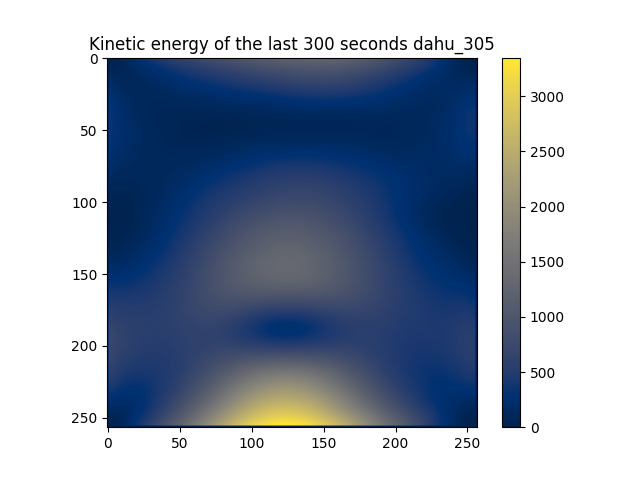

In [426]:
time_start=30
energy_mean=np.mean(energy[-time_start:,:,:],axis=0)
Emin=np.min(energy_mean)
Emax=np.max(energy_mean)

plt.figure()
plt.imshow(energy_mean,cmap='cividis',vmax=Emax,vmin=Emin)
plt.colorbar()
plt.title('Kinetic energy of the last '+str(time_start)+ '0 seconds '+simu_name)
plt.savefig('figures/KE_Picture/KE_picture_'+simu_name+'.png')
plt.show()

## Making a fourier transform of the psi data

(256, 256)


/tmp/ipykernel_4946/3444629991.py:40: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(energy_spectrum ), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=0,vmax=10)


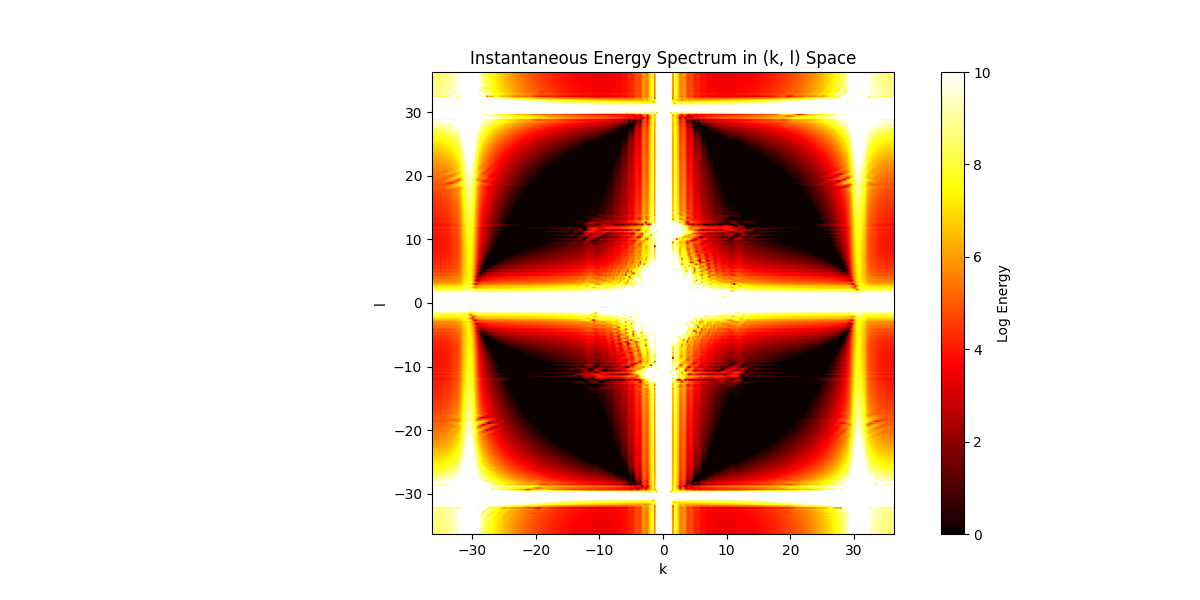

In [427]:

#Making a fourier series of the data:


#Selecting the indice corresponding to the time
time_sel=1
psi_data=psi[time_sel,0,1:,1:]


n = psi_data.shape[0]
dx=Lx/nx/(2*np.pi)
dy=Lx/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)

# 2D Fourier Transform

fft_result = np.fft.fft2(psi_data[:,:])
print(psi_data[:,:].shape)
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
epsilon = 1e-10  # Small value to avoid log(0)


#Calculating Energy
energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2

# Step 3: Plot the Spectrum
plt.figure(figsize=(12, 6))
plt.imshow(np.log(energy_spectrum ), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=0,vmax=10)


plt.colorbar(label='Log Energy')
plt.xlabel('k')
plt.ylabel('l')
plt.title('Instantaneous Energy Spectrum in (k, l) Space')
plt.show()


" Considering the averaged energy spectrum over a few snapshots

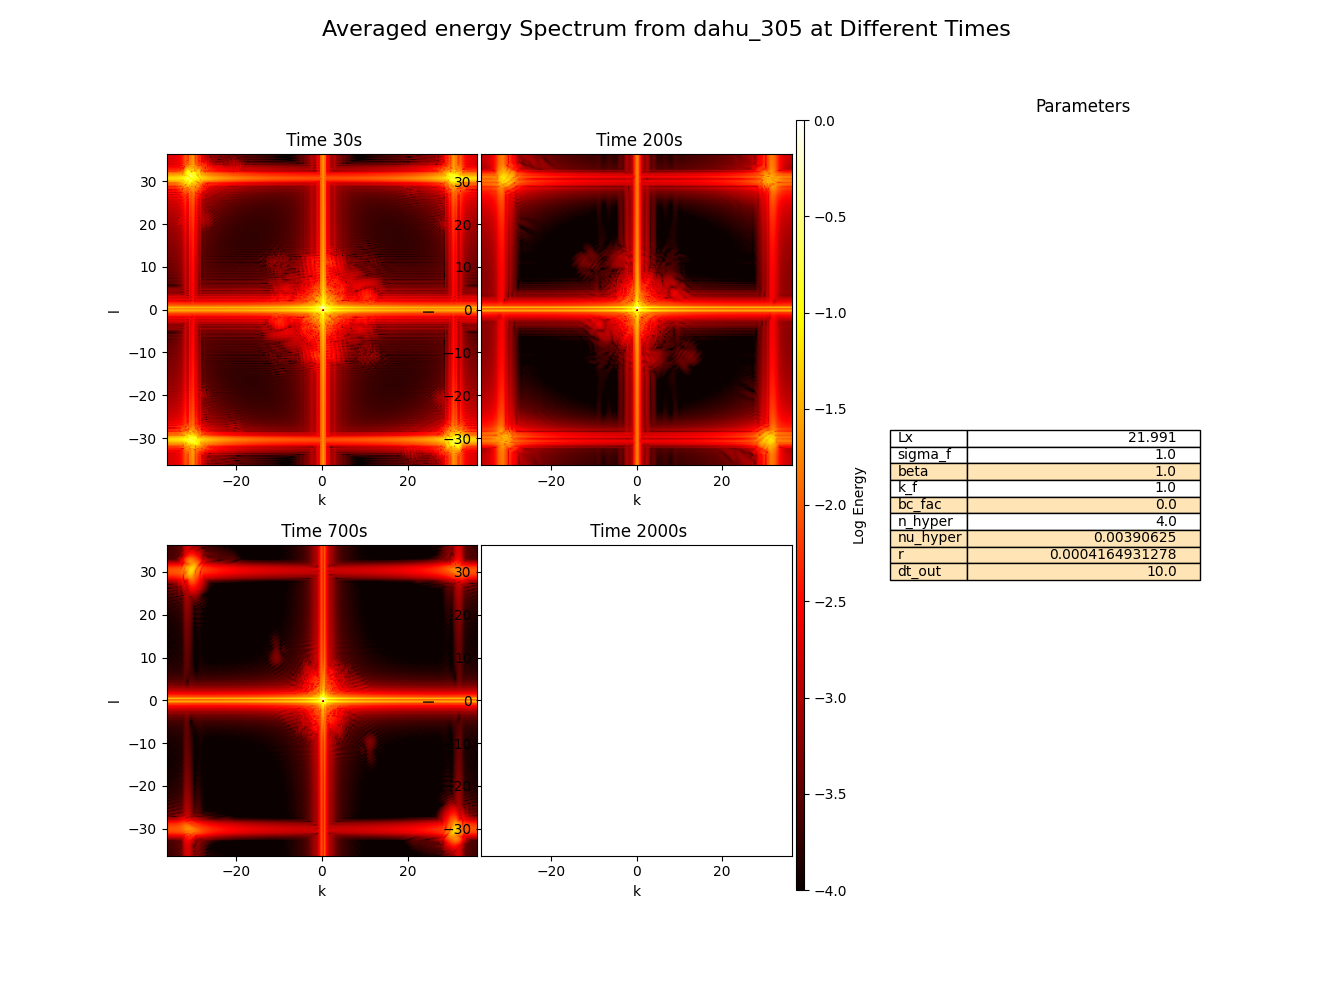

In [428]:


# Define the times to visualize
times_to_plot = [3, 20,70,200]

# Convertir Lx en float avec 3 décimales
Lx_formatted = "{:.3f}".format(Lx)

ratio=5/6
# Création de la figure
fig = plt.figure(figsize=(16*ratio, 12*ratio))

# Grid spec pour diviser la figure en sections
grid = fig.add_gridspec(nrows=2, ncols=5, width_ratios=[4,4,0.1,2,3],hspace=0.03,wspace=0.02)


dx=Lx/nx/(2*np.pi)
dy=Lx/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)



# Loop through each time and plot the corresponding image
for idx, time_sel in enumerate(times_to_plot):
    # Average psi over 5 time steps
    psi_avg = np.mean(psi[time_sel:time_sel+5], axis=0)
    
    # 2D Fourier Transform
    fft_result = np.fft.fft2(psi_avg[0,1:,1:])
    fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
    epsilon = 1e-10  # Small value to avoid log(0)
    #Calculating Energy
    energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2
    #Plotting the Spectrum
    ax = fig.add_subplot(grid[idx // 2, idx % 2])
    img=ax.imshow(np.log(energy_spectrum+epsilon), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=-4)
    ax.set_xlabel('k')
    ax.set_ylabel('l')
    ax.set_title(f' Time {time_sel*10}'+ 's')


ax2=fig.add_subplot(grid[:, 2])

cbar = plt.colorbar(img, cax=ax2)
cbar.set_label('Log Energy')


# Tableau des paramètres sur la droite
param_table = fig.add_subplot(grid[:, 4])
param_table.axis('off')  # Pour enlever les axes

r=f0*hEkb/(dh*2)
colors2D = [['white'] for _ in range(2)] + [['moccasin']] + [['white']] + [['moccasin']] + [['white']] + [['moccasin'] for _ in range(3)]
colors = ['white' for _ in range(2) ] + ['moccasin'] + ['white'] + ['moccasin'] + ['white'] + ['moccasin' for _ in range(3) ]

param_table.table(cellText=[[Lx_formatted], [sigma_f],[beta] , [k_f], [bc_fac], [n_hyper], [nu_hyper], [r] ,[dt_out]],
                  rowLabels=['Lx','sigma_f','beta', 'k_f', 'bc_fac', 'n_hyper', 'nu_hyper', 'r', 'dt_out'],
                  loc='center' ,cellColours=colors2D,rowColours=colors)
param_table.set_title('Parameters')

plt.subplots_adjust(wspace=0.5)  # Adjust horizontal spacing
plt.suptitle('Averaged energy Spectrum from '+str(simu_name)+' at Different Times', fontsize=16)
#plt.tight_layout()
plt.savefig('./figures/Energy_Spectrum_'+str(simu_name)+'.png')
plt.show()


As time increases, the energy goes toward smaller wavenumbers and thus greater scales. There are more energy distributed along the y axis arround the k=0 emphasizing the presence of jets. 

/tmp/ipykernel_4946/571191728.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(energy_spectrum) , extent=(-np.pi, np.pi, -np.pi, np.pi), cmap='Greys', origin='lower')


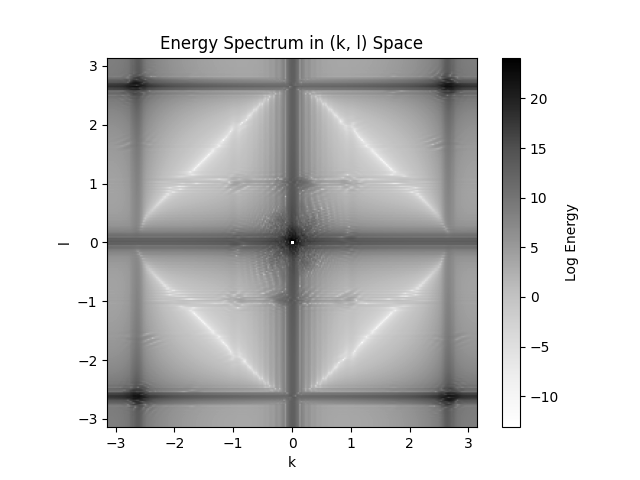

In [429]:
# Assuming ii[10,0,:,:]

fft_result = np.fft.fft2(psi_data)# Step 1: Fourier Transform
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

energy_spectrum = np.abs(fft_shifted) ** 2* k_norm**2

plt.figure()
plt.imshow(np.log(energy_spectrum) , extent=(-np.pi, np.pi, -np.pi, np.pi), cmap='Greys', origin='lower')


plt.colorbar(label='Log Energy')
plt.xlabel('k')
plt.ylabel('l')
plt.title('Energy Spectrum in (k, l) Space')
plt.show()



# Energy dissipation checking
Using Lennard python tools to check things with the simu data

In [430]:
from diagnostics_pkg import operators as op


(138, 257, 257)
Energy dissipated by drag + Energy dissipated by viscosity-Enerjy injected = 98330993.9057732
Energy_diss_drag/Energy_injected 36.199 %


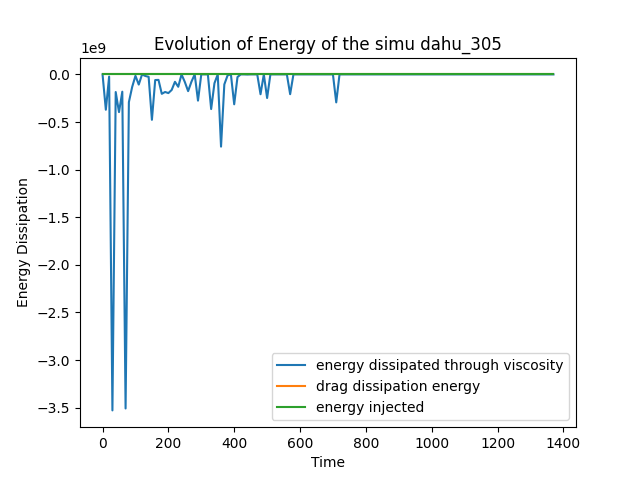

In [431]:

psi_data = psi[:, 0, :, :]
q_data = q[:, 0, :, :]

dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]
Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain

#Calculating the energy
energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
print(np.shape(enstro))
enstro_mean=np.mean(enstro,axis=(1,2))
#Calculating the total enstrophy for each snapshots
enstro_tot=np.sum(enstro,axis=(1,2))


dx=x[-1]/x.shape[0]
r=f0*hEkb/(dh*2)


#energy injectée :
energy_inj=np.zeros_like(energy_totale)
energy_inj[:]=sigma_f**2
energy_diss=-2*energy_totale*r
#enstro_diss=-2*nu_hyper*enstro_mean

#Calculating the enerrgy dissipated by hyper-viscosity
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)
#palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
enstro_diss=-nu_hyper*palenstro_tot 

mean_enstro_diss=np.mean(enstro_diss[:])
mean_energy_diss=np.mean(energy_diss[:])
mean_energy_inj=np.mean(energy_inj[:])
print("Energy dissipated by drag + Energy dissipated by viscosity-Enerjy injected =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7))


ratioE=mean_energy_diss/mean_energy_inj*100
print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')

plt.figure()

plt.plot(t[:],enstro_diss,label='energy dissipated through viscosity')
plt.plot(t[:],energy_diss,label='drag dissipation energy')
plt.plot(t[:],-energy_inj,label='energy injected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Dissipation')
plt.title('Evolution of Energy of the simu '+str(simu_name))
#plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
plt.show()




# Energy cascade

<!-- import numpy as np
import matplotlib.pyplot as plt

# Selecting the index corresponding to the time you want to visualize
time_sel = len(t)-100
averaging_over = 5  # Number of time steps to average over

k = np.arange(1.,nx//2)
epsilon=sigma_f**2
eta=k_f**2*epsilon

#Calculating the wavenumbers:
dx=Lx/nx/(2*np.pi)
dy=Ly/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)


# Get the power spectrum density
psi_fft = np.fft.fft2(psi[time_sel, 0, :, :])
psi_fft_shifted = np.fft.fftshift(psi_fft)
psd = np.abs(psi_fft_shifted)**2*k_norm**2


# Plot the 1D power spectrum density
plt.figure(figsize=(12, 6))
plt.imshow(np.log(psd),extent=(np.min(kx), np.max(kx), np.min(ky), np.max(ky)), cmap='hot', origin='lower',vmin=4,vmax=10)
plt.colorbar(label='Log Energy')
plt.xlabel('kx')
plt.ylabel('ky')
plt.title('Instantaneous Energy Spectrum in (kx, ky) Space at t='+str(t[time_sel])+'s')

psd_1d_avg=np.zeros_like(np.unique(k_norm))
i=0
for time in range(time_sel,time_sel+averaging_over):
    print("chargement de la frame",time)
    psi_data = psi[time, 0, :, :]


    psi_fft = np.fft.fft2(psi_data)
    psi_fft_shifted = np.fft.fftshift(psi_fft)
    psd = np.abs(psi_fft_shifted)**2#*k_norm**2
    psd_1d=np.zeros_like(np.unique(k_norm))
    k_values=np.sort(np.unique(k_norm))
   
                
    #Calculating 1d spectrum
    for idx, kx_v in enumerate(kx_reshaped):
        for idy, ky_v in enumerate(ky_reshaped):
            k_norm_v=np.sqrt(kx_v**2+ky_v**2)#Recalculating the norm of the wavenumber
            indice=np.where(k_values==k_norm_v)
            psd_1d[indice]+=psd[idx,idy]*k_norm_v
    psd_1d_avg+=psd_1d
    i+=1
psd_1d_avg=psd_1d_avg/(i)



#plotting the 1d spectrum

plt.figure()
r=f0*hEkb/(2*dh)
k_beta=(beta**3/epsilon)**(1/5)
kH_E=np.sqrt(r**3/epsilon)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)
plt.axvline(x=kH_E, color='red', linestyle='--', label='$k_{H_E}$')
plt.axvline(x=k_beta, color='cyan', linestyle='--', label='$k_\\beta$')
plt.axvline(x=kh_Z, color='orange', linestyle='--', label='$k_{H_Z}$')
plt.axvline(x=k_f, color='violet', linestyle='--', label='$k_{f}$')
plt.loglog(k_values,psd_1d_avg)
plt.plot(k, 1e6 * k**(-3), color='k')
plt.plot(k, 1e5 * k**(-5/3), color='b')
plt.grid()

plt.xlabel('k')
plt.ylabel('Log Energy')
plt.legend()
plt.show()

#Adding a table with the parameters
fig=plt.figure()

# Tableau des paramètres sur la droite
param_table = fig.add_subplot(1,1,1)
param_table.axis('off')  # Pour enlever les axes

r=f0*hEkb/(dh*2)
colors2D = [['white'] for _ in range(2)] + [['moccasin']] + [['white']] + [['moccasin']] + [['white']] + [['moccasin'] for _ in range(3)]
colors = ['white' for _ in range(2) ] + ['moccasin'] + ['white'] + ['moccasin'] + ['white'] + ['moccasin' for _ in range(3) ]

param_table.table(cellText=[[Lx_formatted], [sigma_f],[beta], [dh] , [k_f], [bc_fac], [nu_hyper], [r] ,[dt_out]],
                  rowLabels=['Lx','sigma_f','beta', 'dh', 'k_f', 'bc_fac', 'nu_hyper', 'r', 'dt_out'],
                  loc='center' ,cellColours=colors2D,rowColours=colors)
param_table.set_title('Parameters',y=0.2)
 -->


## Energy Spectrum with Bruno code

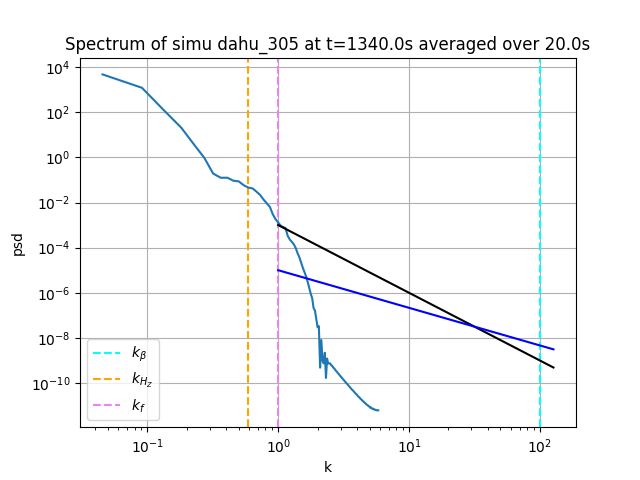

In [432]:
#Plotting the 1D spec using Bruno's code
time_sel=-4
averaging_over=2

psi_data = psi[time_sel, 0, :, :]
q_data = q[time_sel, 0, :, :]
kr, spec1d=qg.fftlib.get_spec_1D(psi_data, q_data, dx,window="hanning", all_kr= False, averaging='radial')

spec1d_avg=np.zeros_like(spec1d)
for time in range(time_sel,time_sel+averaging_over):
    psi_data = psi[time, 0, :, :]
    q_data = q[time, 0, :, :]
    kr, spec1d=qg.fftlib.get_spec_1D(psi_data, q_data, dx,window="hanning", all_kr= False, averaging='radial')
    spec1d_avg+=spec1d

spec1d_avg=spec1d_avg/averaging_over
eta=epsilon*k_f**2
r=f0*hEkb/(2*dh)
k_beta=(beta**3/epsilon)**(1/5)
kH_E=np.sqrt(r**3/epsilon)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)

plt.figure()

#plt.axvline(x=kH_E, color='red', linestyle='--', label='$k_{H_E}$')
plt.axvline(x=k_beta, color='cyan', linestyle='--', label='$k_\\beta$')
plt.axvline(x=kh_Z, color='orange', linestyle='--', label='$k_{H_Z}$')
plt.axvline(x=k_f, color='violet', linestyle='--', label='$k_{f}$')


plt.loglog(kr,np.abs(spec1d))
k = np.arange(1.,nx//2)
plt.plot(k, 1e-3 * k**(-3), color='k')
plt.plot(k, 1e-5 * k**(-5/3), color='b')
plt.title('Spectrum of simu '+ str(simu_name)+' at t='+str(t[time_sel])+'s averaged over '+ str(averaging_over*dt_out)+'s')
plt.xlabel('k')
plt.ylabel('psd')
plt.legend()

plt.grid()

# Check parameters

In [433]:
#Estimation du temps pour que l'énergie injecté atteigne l'équilibre- bavec l'énergie dissipée

r=f0*hEkb/(2*dh)
print("r=",r,"\nT=",1/r,"s Wich correspond to the time it takes to reach energy flux balance")


print(param)

r= 0.0004164931278 
T= 2401.0000003654322 s Wich correspond to the time it takes to reach energy flux balance
{'NX': 256.0, 'NY': 256.0, 'nl': 1.0, 'Lx': 21.99114857512855, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00390625, 'n_hyper': 4.0, 'hEkb': 0.0004164931278, 'tend': 1576800000000.0, 'dt_out': 10.0}


In [434]:
#Parameters of the simu:

epsilon=sigma_f**2
eta=k_f**2*sigma_f**2
print("Here are the parameters of the simu : "+simu_name)
kh_E=np.sqrt(r**3/epsilon)#*(np.pi*2)
k_beta=(beta**3/epsilon)**(1/5)#*(np.pi*2)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)#*(np.pi*2)

print("nx=",nx,"\nn_hyper=",n_hyper,"\nsigma_f=",sigma_f,"\nbeta=",beta,"\nk_f=",k_f,"\nnu_hyper=",nu_hyper,"\nr(=hEkb)=",r)
print("epsilon",epsilon)
print("\nThe caracteristics wave numbers are :")
print("kh_E=",kh_E,'\nk_beta=',k_beta,'\nk_f=',k_f,"\nkh_Z=",kh_Z)
print("(kh_Z should tend toward the wavenumber resolution:",round(2*np.pi*nx/Lx,4),")")


print("\nYou have to run your simu for at least: ",round(1/r,4),"s")

print("kh_Z/k_f=",kh_Z/k_f,"This should be far greater than 1")
print("kh_E/k_f=",kh_E/k_f, "This should be far smaller than 1")



#Calculating the Zonostrophy

Z_val= (beta**2*epsilon/(r**5))**(1/20)

k_betar=beta**0.5/(epsilon/r)**(1/4)#*(np.pi*2)
k_epsilon=(beta**3/epsilon)**(1/5)#*(np.pi*2)
print("\nThe Zonostrophy is: ",Z_val)
print("the Rhines wavenumber should be: ", k_betar )

print('\033[91mThe Occupation is Oc=L_betar/L=\033[0m'+'\033[91m'+str((epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4))+'\033[0m')
alpha=k_f/k_epsilon

Here are the parameters of the simu : dahu_305
nx= 256.0 
n_hyper= 4.0 
sigma_f= 1.0 
beta= 1.0 
k_f= 1.0 
nu_hyper= 0.00390625 
r(=hEkb)= 0.0004164931278
epsilon 1.0

The caracteristics wave numbers are :
kh_E= 8.499859750373568e-06 
k_beta= 1.0 
k_f= 1.0 
kh_Z= 4.0
(kh_Z should tend toward the wavenumber resolution: 73.1429 )

You have to run your simu for at least:  2401.0 s
kh_Z/k_f= 4.0 This should be far greater than 1
kh_E/k_f= 8.499859750373568e-06 This should be far smaller than 1

The Zonostrophy is:  7.0000000002663505
the Rhines wavenumber should be:  0.14285714285170714
The Occupation is Oc=L_betar/L=2.000000052836732


## Checking differents scales

nx= 256.0 
Lx= 21.991148 
n_hyper= 4.0 
sigma_f= 1.0 
beta= 1.0 
k_f= 1.0 
nu_hyper= 0.00390625 
r(=hEkb)= 0.0004164931278

In order to have these parameters :
kh_E= 5.340619389663435e-05 
k_beta= 6.283185307179586 
k_f= 1.0 
kh_Z= 25.132741228718345

You have to run your simu for at least:  2401.0 s

The Zonostrophy is:  7.0000000002663505
the Rhines wavenumber should be:  0.8975979009915016
The Occupation is Oc=L_betar/L= 0.05066059315953895

L/L_epsi=  138.17445797016515   Ok si L/L_epsilon>1


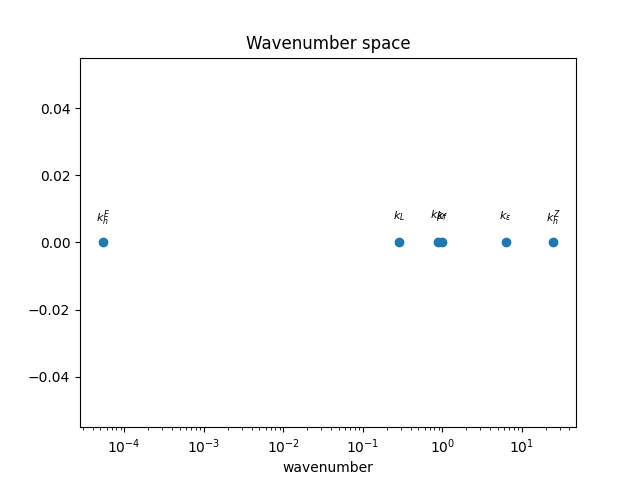

kh_Z/kf= 25.132741228718345
kh_E/kf= 5.340619389663435e-05
k_eps/k_f 6.283185307179586


In [435]:
#Checking the differents scales:
Lx_c=Lx       #6.283185307179586
nx_c=nx

sigma_f_c=sigma_f
epsilon=sigma_f_c**2

beta_c=beta

k_f_c=k_f
nu_hyper_c=nu_hyper
n_hyper_c=n_hyper
r_c=r


eta=k_f_c**2*epsilon
kh_E=np.sqrt(r_c**3/epsilon)*(np.pi*2)
k_beta=(beta_c**3/epsilon)**(1/5)*(np.pi*2)
k_betar=beta_c**0.5/(epsilon/r_c)**(1/4)*(np.pi*2)
kh_Z=(eta**(1/3)/(nu_hyper_c))**(1/n_hyper_c)*(np.pi*2)
Z_val= (beta_c**2*epsilon/(r_c**5))**(1/20)
k_epsilon=(beta_c**3/epsilon)**(1/5)*(np.pi*2)
k_L=1/Lx_c*(np.pi*2)
print("nx=",nx_c,"\nLx=",Lx_c,"\nn_hyper=",n_hyper_c,"\nsigma_f=",sigma_f_c,"\nbeta=",beta_c,"\nk_f=",k_f_c,"\nnu_hyper=",nu_hyper_c,"\nr(=hEkb)=",r_c)

print("\nIn order to have these parameters :")
print("kh_E=",kh_E,'\nk_beta=',k_beta,'\nk_f=',k_f_c,"\nkh_Z=",kh_Z)
#print("(kh_Z should tend toward the wavenumber resolution:",round(2*np.pi*nx_c/Lx,4),")")


print("\nYou have to run your simu for at least: ",round(1/r_c,4),"s")


"""
print("\nkh_Z/k_f_c=",kh_Z/k_f_c,"This should be far greater than 1")
print("\nkh_E/k_f_c=",kh_E/k_f_c, "This should be far smaller than 1")
print("kh_beta/k_f_c=",k_beta/k_f_c, "This should be far smaller than 1")
"""

print("\nThe Zonostrophy is: ",Z_val)
print("the Rhines wavenumber should be: ", k_betar )

print('\033[91mThe Occupation is Oc=L_betar/L=\033[0m',1/(k_betar*Lx_c))
print("\nL/L_epsi= ",Lx_c*k_epsilon,"  Ok si L/L_epsilon>1")#/(np.pi*2)


tab2plot=np.array([kh_E,k_betar,k_epsilon,k_f_c,kh_Z,k_L])
zeros=np.zeros_like(tab2plot)       
simu_name_tab=[r'$k_h^E$',r'$k_{\beta r}$',r'$k_\epsilon$',r'$k_f$',r'$k_h^Z$',r'$k_L$']
plt.figure()

# Plotting the scatter plot
plt.scatter(tab2plot, zeros)

# Adding text above each point
for i, desc in enumerate(simu_name_tab):
   plt.text(tab2plot[i], 0.01, desc, fontsize=8, ha='center', va='top')
   
plt.xlabel('wavenumber')
plt.xscale('log')
plt.title('Wavenumber space')

plt.show()
print("kh_Z/kf=",kh_Z/k_f)
print("kh_E/kf=",kh_E/k_f) 
print("k_eps/k_f",k_epsilon/k_f)


In [436]:
#Printing the Rhines scale
psi_data=psi[:,0,:,:]
u,v=op.calc_uv(psi_data[-50:-1,:,:],dx,bc_fac)
U=np.sqrt(u**2+v**2)

Rh=np.sqrt(np.mean(U[:,:,:])/beta)
k_rh=1/Rh*np.pi*2
print("The Rhines scale is : Rh=",Rh)
print("$k_{Rh}$=",k_rh)


The Rhines scale is : Rh= 5.4132398385816245
$k_{Rh}$= 1.1607069877816285


## Finding the parameters

In [437]:
#Taking the parameters of the simulation

n_hyper_c=n_hyper
#Selecting the Ocupation you want
Oc=0.016250740776550292
Z=2.817585085135084

epsilon_computed=(Lx*Oc/(Z*beta_c**(2/5)))**5


r_computed=epsilon_computed/((beta_c**(1/2)*Lx_c*Oc))**(4)

print("Résolution minimale : ",2*(5*k_f))

nu_c=k_f**(2/3)*epsilon_computed**(1/3)/(5*k_f)**n_hyper_c
print("dissipation r=",r_computed)
print("viscosité min:",nu_c )
print("sigma_f=",epsilon_computed**0.5)


Résolution minimale :  10.0
dissipation r= 0.002012499890906703
viscosité min: 5.123027531184954e-05
sigma_f= 0.005729412097049756


In [438]:
#On fixe le ratio kf/kh_Z et kf/k_epsilon 
alpha=k_f/k_epsilon


#Choix des valeurs d'Ocupation, de Zonostrophie et de la taille du domaine

Oc=Oc
Z=Z
Lx = 37
n_hyper_c=n_hyper

#Calcul de epsilon
epsilon_computed=Z / ((k_f/alpha)*Lx*Oc)

#Calcul du beta correspondant:
beta_computed=((k_f/alpha)**5 * epsilon_computed)**(1/3)

#Calcul de r 
#r_computed=( epsilon_computed**(1/12) / (((k_f/alpha))**(5/6)*Lx*Oc) )**4
r_computed=( beta_computed**(1/10)*epsilon_computed**(1/20) / Z )**4

#Calcul de nu_hyper
nu_computed=k_f**(2/3-n_hyper_c) * epsilon_computed**(1/3) / (5**n_hyper_c)

#Calcul de la résolution minimale (2 fois la fréquence de dissipation de l'enstrophie)
Res=2*((epsilon_computed*k_f**2)**(1/3) / nu_computed )**1/n_hyper_c

print("epsilon=",epsilon_computed)

print("\nsigma_f=",epsilon_computed**0.5)
print("r=",r_computed)
print("nu_hyper=",nu_computed)

print("\nRésolution minimale=",Res)
print("alpha=",alpha)


epsilon= 0.7457998377598328

sigma_f= 0.863597034362574
r= 0.04899508494674788
nu_hyper= 0.0014509777211567914

Résolution minimale= 312.5
alpha= 0.15915494309189535
